In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import sklearn.decomposition as sk

In [4]:
merged_data = pd.DataFrame(pd.read_pickle('../raw_merged_data_v2'))
merged_data_1985 = pd.DataFrame(pd.read_pickle('../raw_merged_data_v2_withinyears'))
#missing_dropped = merged_data.dropna(axis=1, how='all', ignore_index=True)
#dropped = missing_dropped.drop(['Lifetime risk of maternal death (1 in: rate varies by country)', 'Lifetime risk of maternal death (%)', 'Number of maternal deaths'], axis=1)

### All data

In [5]:
merged_relevant = merged_data[merged_data['date'] > 1984]
merged_relevant = merged_relevant[merged_relevant['date'] < 2019]
merged_relevant = merged_relevant.drop(columns=['Maternal mortality ratio (modeled estimate, per 100,000 live births)'], axis=1)

In [6]:
merged_features = merged_relevant.drop(columns=['Maternal mortality ratio (national estimate, per 100,000 live births)'], axis=1)

Text(0, 0.5, 'Proportion of Missing Feature Data per Year')

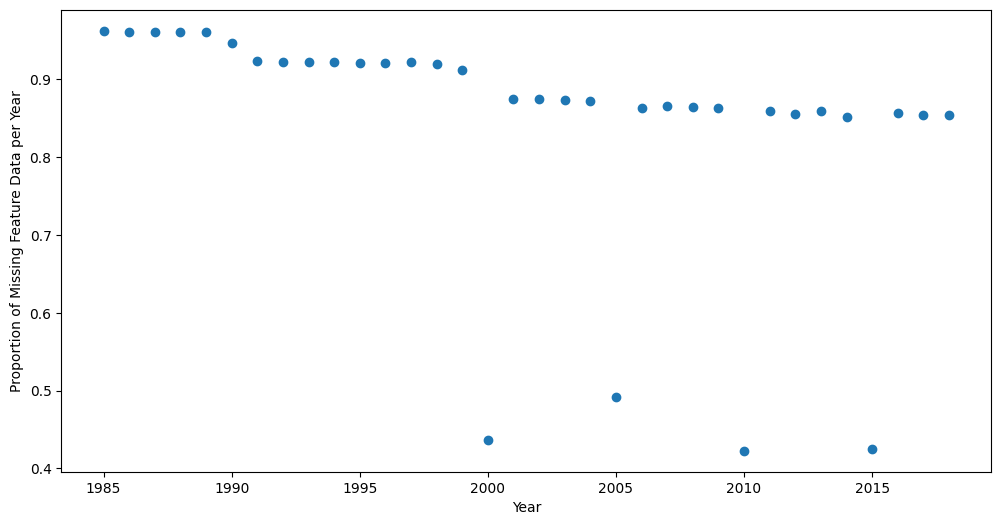

In [7]:
merged_data_peryear = (
    merged_features.groupby('date')
    .apply(lambda x: x.isna().sum().sum() / (x.shape[0] * x.shape[1]))
    .drop(columns='date', errors='ignore')  # Drop 'year' column if present
)

fig = plt.figure(figsize=(12, 6))
plt.scatter(merged_data_peryear.index, merged_data_peryear)
#plt.title('Proportion of Missing National and Modelled MMR Estimates Per Year')
plt.xlabel('Year')
plt.ylabel('Proportion of Missing Feature Data per Year')

In [8]:
pd.DataFrame(merged_data_peryear).sort_values(by=0, ascending=True).head(10)

,0
date,
2010.0,0.422663
2015.0,0.425480
2000.0,0.436086
2005.0,0.491948
2014.0,0.851984
2017.0,0.854338
2018.0,0.854611
2012.0,0.855907
2016.0,0.856650


In [9]:
feature_missing = merged_features.isna().mean()
pd.DataFrame(feature_missing).sort_values(by=0)[160:170]

,0
"Literacy rate, youth total (% of people ages 15-24) female",0.896429
"Prevalence of stunting, height for age (% of children under 5)",0.897427
"Educational attainment, Doctoral or equivalent, population 25+ (%) (cumulative) female",0.900421
"Educational attainment, Doctoral or equivalent, population 25+ (%) (cumulative) male",0.900421
"Literacy rate, youth total (% of people ages 15-24) male",0.903415
"Prevalence of overweight, weight for height (% of children under 5)",0.905855
Trained teachers in preprimary education (% of total teachers) female,0.908073
2.E.06 Other neurological disorders prevalence (age standardized) (per 100 000 population) male,0.913950
2.F.0 Mental disorders prevalence (age standardized) (per 100 000 population) female,0.913950
2.E.07 Headache disorders prevalence (age standardized) (per 100 000 population) male,0.913950


### Correlation Between Features

In [88]:
import pickle
with open('../split_income_models/countries_dict.pkl', 'rb') as f:
    countries_dict = pickle.load(f)

In [91]:
without_setting = merged_relevant.copy()
without_setting['setting'] = without_setting['setting'].map(countries_dict)

In [96]:
without_setting = without_setting.dropna(axis=1, how='all', ignore_index=True)
without_setting = without_setting.dropna(subset=['Maternal mortality ratio (national estimate, per 100,000 live births)'])
without_setting = without_setting[without_setting['income_num'] != 0]
features_data = without_setting.drop(columns=['Maternal mortality ratio (national estimate, per 100,000 live births)'], axis=1)

In [ ]:
#without_setting = merged_features.drop(columns=['setting'], axis=1)

In [97]:
f_corr = features_data.corr()
upper_tri = f_corr.where(
    ~np.tril(np.ones(f_corr.shape)).astype(bool)
)

# Flatten and drop NaNs
correlation_values = upper_tri.stack().values

Text(0, 0.5, 'Frequency')

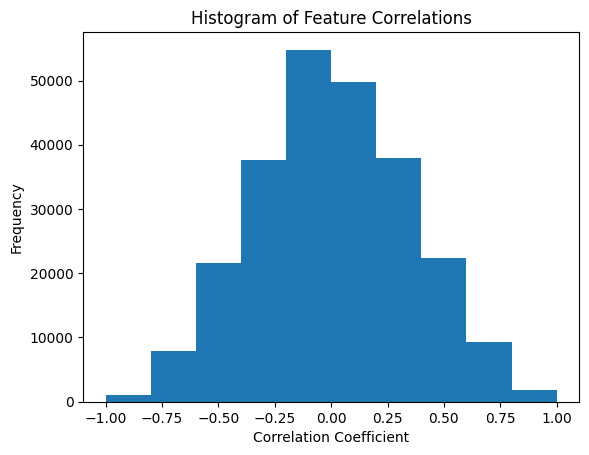

In [98]:
plt.hist(correlation_values)
plt.title('Histogram of Feature Correlations')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Frequency')

In [99]:
high_correlations = upper_tri.stack().reset_index()
high_correlations.columns = ['feature1', 'feature2', 'correlation']
high_correlations = high_correlations[high_correlations['correlation'].abs() > 0.95]
high_correlations.reset_index(drop=True, inplace=True)
high_correlations

,feature1,feature2,correlation
0,date,"Women and girls who use menstrual materials, u...",-0.979144
1,Women and girls who use menstrual materials (%...,Pregnant women receiving prenatal care (%),1.000000
2,Women and girls who use menstrual materials (%...,"Prevalence of underweight, weight for age (% o...",-1.000000
3,Women and girls who use menstrual materials (%...,Unmet need for contraception (% of married wom...,1.000000
4,Women and girls who use menstrual materials (%...,"Prevalence of overweight, weight for height, m...",-1.000000
...,...,...,...
623,Child employment in agriculture (% of economic...,Child employment in services (% of economicall...,-0.974203
624,Child employment in agriculture (% of economic...,Child employment in services (% of economicall...,-0.966356
625,Trained teachers in lower secondary education ...,Trained teachers in secondary education (% of ...,0.984652
626,Trained teachers in lower secondary education ...,Trained teachers in secondary education (% of ...,0.975127


In [174]:
missing_data = pd.DataFrame(index = high_correlations.index, columns=['feature1_missing', 'feature2_missing'])
for i, row in high_correlations.iterrows():
    feature1 = row['feature1']
    feature2 = row['feature2']
    missing_data.at[i, 'feature1_missing'] = merged_features[feature1].isna().mean()
    missing_data.at[i, 'feature2_missing'] = merged_features[feature2].isna().mean()
high_correlations = pd.concat([high_correlations, missing_data], axis=1)
high_correlations 

,feature1,feature2,correlation,feature1_missing,feature2_missing
0,Women and girls who use menstrual materials (%...,Women participating in own health care decisio...,0.968715,0.996895,0.98126
1,Women and girls who use menstrual materials (%...,Knowledge of any method of contraception (% of...,1.000000,0.996895,0.973608
2,Women and girls who use menstrual materials (%...,Demand for family planning satisfied by any me...,0.995970,0.996895,0.970725
3,Women and girls who use menstrual materials (%...,Knowledge of any modern method of contraceptio...,1.000000,0.996895,0.973608
4,Women and girls who use menstrual materials (%...,Women participating in none of the three decis...,-0.968308,0.996895,0.981371
...,...,...,...,...,...
579,"Educational attainment, at least Master's or e...","Educational attainment, at least Master's or e...",0.952083,0.893435,0.893435
580,Child employment in agriculture (% of economic...,Child employment in services (% of economicall...,-0.969591,0.983367,0.983367
581,Trained teachers in lower secondary education ...,Trained teachers in secondary education (% of ...,0.980522,0.931249,0.916833
582,Trained teachers in lower secondary education ...,Trained teachers in secondary education (% of ...,0.971133,0.931249,0.916944


In [175]:
differing_missingness = pd.DataFrame(index = high_correlations.index, columns=['correlation', 'feature1', 'feature1_missing', 'feature2', 'feature2_missing'])
for i, row in high_correlations.iterrows():
    if abs(row['feature1_missing'] - row['feature2_missing']) > 0.2:
        differing_missingness.at[i, 'correlation'] = row['correlation']
        differing_missingness.at[i, 'feature1'] = row['feature1']
        differing_missingness.at[i, 'feature1_missing'] = row['feature1_missing']
        differing_missingness.at[i, 'feature2'] = row['feature2']
        differing_missingness.at[i, 'feature2_missing'] = row['feature2_missing']

differing_missingness = differing_missingness.dropna().reset_index(drop=True)

differing_missingness 


,correlation,feature1,feature1_missing,feature2,feature2_missing
0,-0.978075,"Mortality rate, infant (per 1,000 live births)",0.106676,"Probability of Survival to Age 5, Male",0.944112
1,-0.973634,"Mortality rate, infant (per 1,000 live births)",0.106676,"Probability of Survival to Age 5, Female",0.944112
2,-0.976495,"Mortality rate, infant (per 1,000 live births)",0.106676,Probability of Survival to Age 5,0.944112
3,0.956445,"Survival to age 65, female (% of cohort)",0.000887,"Survival Rate from Age 15-60, Female",0.944666
4,0.976574,"Number of infant deaths, male",0.107563,Number of maternal deaths,0.509093
5,0.993582,"Number of infant deaths, male",0.107563,Number of stillbirths,0.492238
6,-0.983813,"Mortality rate, under-5, male (per 1,000 live ...",0.106676,"Probability of Survival to Age 5, Male",0.944112
7,-0.98225,"Mortality rate, under-5, male (per 1,000 live ...",0.106676,"Probability of Survival to Age 5, Female",0.944112
8,-0.983561,"Mortality rate, under-5, male (per 1,000 live ...",0.106676,Probability of Survival to Age 5,0.944112
9,-0.976975,"Probability of Survival to Age 5, Male",0.944112,"Mortality rate, infant, female (per 1,000 live...",0.106676


In [176]:
feature_counts = {}

for i, row in differing_missingness.iterrows():
    feature1 = row['feature1']
    feature2 = row['feature2']
    if feature1 not in feature_counts:
        feature_counts[feature1] = 0
    if feature2 not in feature_counts:
        feature_counts[feature2] = 0
    feature_counts[feature1] += 1
    feature_counts[feature2] += 1

feature_counts_df = pd.DataFrame(index = feature_counts.keys(), data=feature_counts.values(), columns=['count']).sort_values(by='count', ascending=False)
feature_counts_df

,count
"Probability of Survival to Age 5, Female",6
Probability of Survival to Age 5,6
"Probability of Survival to Age 5, Male",6
Number of maternal deaths,5
Number of stillbirths,5
"Mortality rate, infant (per 1,000 live births)",3
"Mortality rate, infant, female (per 1,000 live births)",3
"Mortality rate, under-5 (per 1,000 live births)",3
"Mortality rate, infant, male (per 1,000 live births)",3
"Mortality rate, under-5, female (per 1,000 live births)",3


### MMR Correlation

In [177]:
mmr_with_setting = merged_relevant.copy()
mmr_with_setting['setting'] = mmr_with_setting['setting'].map(countries_dict)
mmr_with_setting = mmr_with_setting.dropna(axis=1, how='all', ignore_index=True)
mmr_with_setting = mmr_with_setting.dropna(subset=['Maternal mortality ratio (national estimate, per 100,000 live births)'])
mmr_with_setting = mmr_with_setting[mmr_with_setting['income_num'] != 0]
mmr_with_setting = mmr_with_setting.drop(['Lifetime risk of maternal death (1 in: rate varies by country)', 'Lifetime risk of maternal death (%)', 'Number of maternal deaths'], axis=1)

f_corr_mmr = mmr_with_setting.corr()
upper_tri_mmr = f_corr_mmr.where(
    ~np.tril(np.ones(f_corr_mmr.shape)).astype(bool)
)

# Flatten and drop NaNs
correlation_values_mmr = upper_tri_mmr.stack().values
high_correlations_mmr = upper_tri_mmr.stack().reset_index()
high_correlations_mmr.columns = ['feature1', 'feature2', 'correlation']
high_correlations_mmr = high_correlations_mmr[high_correlations_mmr['correlation'].abs() > 0.60]

In [101]:
mmr_with_setting[['setting', 'Maternal mortality ratio (national estimate, per 100,000 live births)']].corr()

,setting,"Maternal mortality ratio (national estimate, per 100,000 live births)"
setting,1.000000,-0.152381
"Maternal mortality ratio (national estimate, per 100,000 live births)",-0.152381,1.000000


In [178]:
mmr_column = 'Maternal mortality ratio (national estimate, per 100,000 live births)'
mmr_correlations = high_correlations_mmr[
    (high_correlations_mmr['feature1'] == mmr_column) | (high_correlations_mmr['feature2'] == mmr_column)
]
mmr_correlations['absolute_corr'] = mmr_correlations['correlation'].abs()
mmr_correlations.sort_values(by='absolute_corr', ascending=False)

/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_5754/101164747.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mmr_correlations['absolute_corr'] = mmr_correlations['correlation'].abs()


,feature1,feature2,correlation,absolute_corr
785,Women and girls who use menstrual materials (%...,"Maternal mortality ratio (national estimate, p...",0.995959,0.995959
88156,Probability of Survival to Age 5,"Maternal mortality ratio (national estimate, p...",-0.869512,0.869512
60302,"Probability of Survival to Age 5, Female","Maternal mortality ratio (national estimate, p...",-0.867849,0.867849
32213,"Probability of Survival to Age 5, Male","Maternal mortality ratio (national estimate, p...",-0.867237,0.867237
108616,"Maternal mortality ratio (national estimate, p...",1.F.01 Maternal disorders prevalence (age stan...,0.848715,0.848715
...,...,...,...,...
108538,"Maternal mortality ratio (national estimate, p...",1.B.02 Lower respiratory infections prevalence...,0.602992,0.602992
108944,"Maternal mortality ratio (national estimate, p...",Vulnerable employment (% of total employment) ...,0.602339,0.602339
106958,"Fraction of Children Under 5 Not Stunted, Female","Maternal mortality ratio (national estimate, p...",-0.601882,0.601882
17014,"Cause of death, by non-communicable diseases, ...","Maternal mortality ratio (national estimate, p...",-0.601130,0.601130


### Saving Features with High Correlation

In [112]:
corr_60 = set()
for index, row in mmr_correlations.iterrows():
    if row['feature1'] != 'Maternal mortality ratio (national estimate, per 100,000 live births)':
        corr_60.add(row['feature1'])
    if row['feature2'] != 'Maternal mortality ratio (national estimate, per 100,000 live births)':
        corr_60.add(row['feature2'])

In [116]:
corr_70 = set()
for index, row in mmr_correlations.iterrows():
    if row['feature1'] != 'Maternal mortality ratio (national estimate, per 100,000 live births)':
        corr_70.add(row['feature1'])
    if row['feature2'] != 'Maternal mortality ratio (national estimate, per 100,000 live births)':
        corr_70.add(row['feature2'])

In [120]:
corr_80 = set()
for index, row in mmr_correlations.iterrows():
    if row['feature1'] != 'Maternal mortality ratio (national estimate, per 100,000 live births)':
        corr_80.add(row['feature1'])
    if row['feature2'] != 'Maternal mortality ratio (national estimate, per 100,000 live births)':
        corr_80.add(row['feature2'])

In [121]:
len(corr_60), len(corr_70), len(corr_80)

(113, 45, 11)

In [122]:
with open('../feature_selection_models/corr_60.pkl', 'wb') as f:
    pickle.dump(corr_60, f)

with open('../feature_selection_models/corr_70.pkl', 'wb') as f:
    pickle.dump(corr_70, f)

with open('../feature_selection_models/corr_80.pkl', 'wb') as f:
    pickle.dump(corr_80, f)

In [123]:
for index, row in mmr_correlations.iterrows():
    if row['feature1'] != 'Maternal mortality ratio (national estimate, per 100,000 live births)':
        print(row['feature1'])
    else: print(row['feature2'])
    print(row['correlation'])
    print("*****************")
    break

Women and girls who use menstrual materials (% of women and girls ages 15-49 who had a menstrual period within the last year)
0.9959587197839146
*****************


In [173]:
a = pd.DataFrame([[5, 9, 4, 'NaN'], [10, 'NaN', 'NaN', 10], [7, 12, 11, 'NaN']])
a.corr()

,0,1,2,3
0,1.0,1.0,1.0,NaN
1,1.0,1.0,1.0,NaN
2,1.0,1.0,1.0,NaN
3,NaN,NaN,NaN,NaN


### MMR Trends

Text(0.5, 1.0, 'National Maternal Mortality Ratio Over Time')

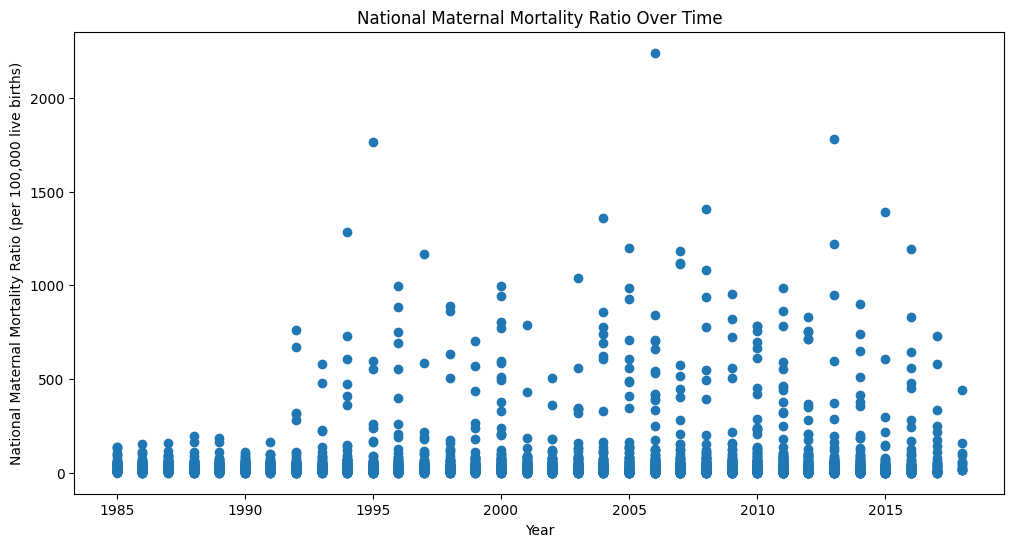

In [ ]:
fig = plt.figure(figsize=(12, 6))
 
plt.scatter(merged_relevant['date'], merged_relevant['Maternal mortality ratio (national estimate, per 100,000 live births)'])
plt.xlabel('Year')
plt.ylabel('National Maternal Mortality Ratio (per 100,000 live births)')
plt.title('National Maternal Mortality Ratio Over Time')

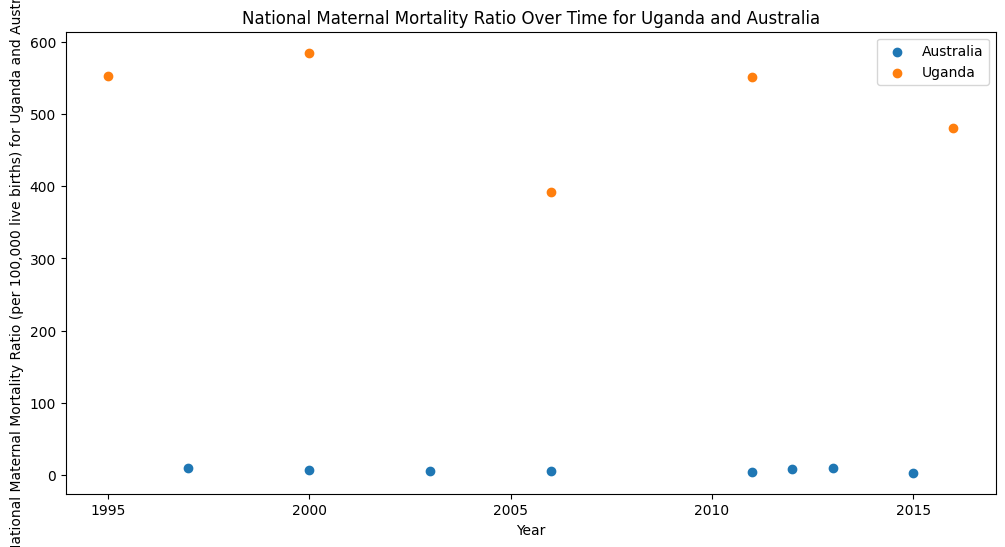

In [48]:
fig = plt.figure(figsize=(12, 6))

plt.scatter(merged_relevant[merged_relevant['setting'] == 'Australia']['date'], merged_relevant[merged_relevant['setting'] == 'Australia']['Maternal mortality ratio (national estimate, per 100,000 live births)'] ,label='Australia')
plt.scatter(merged_relevant[merged_relevant['setting'] == 'Uganda']['date'], merged_relevant[merged_relevant['setting'] == 'Uganda']['Maternal mortality ratio (national estimate, per 100,000 live births)'], label='Uganda')
plt.xlabel('Year')
plt.ylabel('National Maternal Mortality Ratio (per 100,000 live births) for Uganda and Australia')
plt.title('National Maternal Mortality Ratio Over Time for Uganda and Australia')
plt.legend()

Text(0.5, 1.0, 'National Maternal Mortality Ratio Over Time for Tanzania')

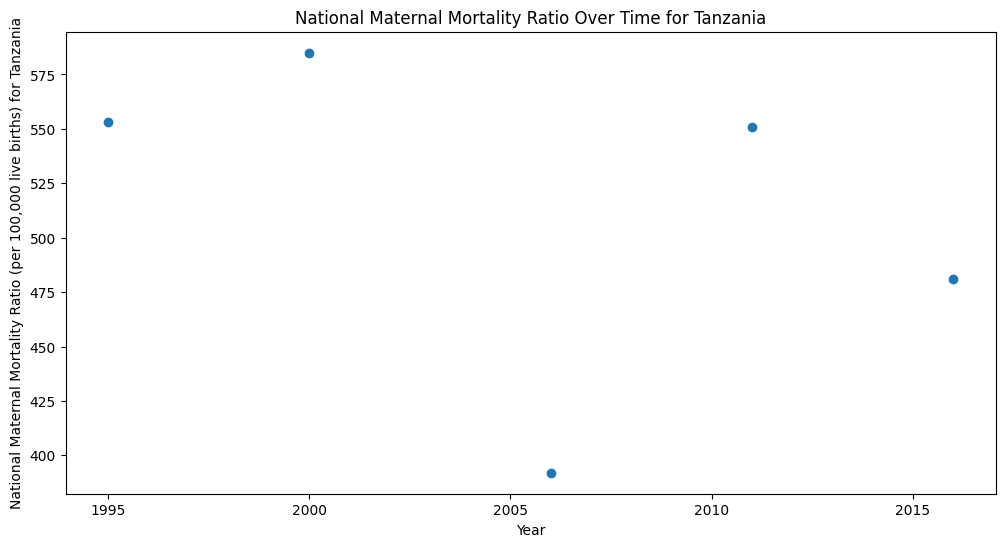

In [ ]:
fig = plt.figure(figsize=(12, 6))

plt.scatter(merged_relevant[merged_relevant['setting'] == 'Uganda']['date'], merged_relevant[merged_relevant['setting'] == 'Uganda']['Maternal mortality ratio (national estimate, per 100,000 live births)'])
plt.xlabel('Year')
plt.ylabel('National Maternal Mortality Ratio (per 100,000 live births) for Tanzania')
plt.title('National Maternal Mortality Ratio Over Time for Uganda')

### PCA

In [1]:
from sklearn.impute import KNNImputer

In [12]:
import pickle 
with open('../split_year_data/countries_dict.pkl', 'rb') as f:
    countries_dict_year = pickle.load(f)

In [ ]:
merged_relevant_dropped = merged_relevant.dropna(axis=1, how='all', ignore_index=True)
merged_relevant_dropped = merged_relevant_dropped.dropna(subset=['Maternal mortality ratio (national estimate, per 100,000 live births)'])

In [131]:
m_features = merged_relevant_dropped.drop(columns=['Maternal mortality ratio (national estimate, per 100,000 live births)'], axis=1)
m_features = m_features[m_features['income_num'] != 0]
merged_relevant_dropped = merged_relevant_dropped[merged_relevant_dropped['income_num'] != 0]

In [126]:
knn_imputer = KNNImputer(n_neighbors=5)
m_features_senc = m_features.copy()
m_features_senc['setting'] = m_features_senc['setting'].map(countries_dict_year)
merged_features_imputed = knn_imputer.fit_transform(m_features_senc)

In [127]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
m_standardised = scaler.fit_transform(merged_features_imputed)

In [179]:
from sklearn.decomposition import PCA
pca = PCA()
X_pca = pca.fit_transform(m_standardised)

In [185]:
pca.explained_variance_ratio_[:5]

array([0.30706679, 0.08505238, 0.05613207, 0.0341834 , 0.02730749])

<BarContainer object of 10 artists>

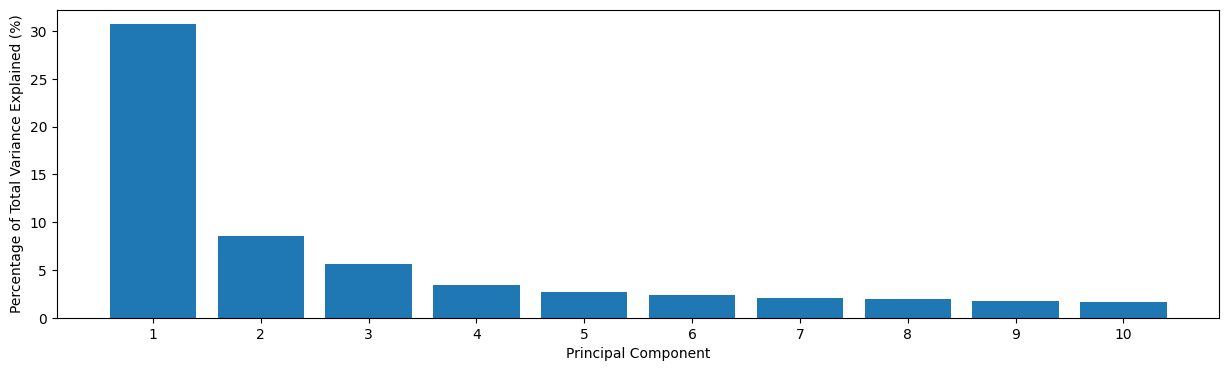

In [193]:
plt.figure(figsize=(15, 4))
plt.xlabel('Principal Component')
plt.ylabel('Percentage of Total Variance Explained (%)')
plt.bar(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'], pca.explained_variance_ratio_[:10]*100)

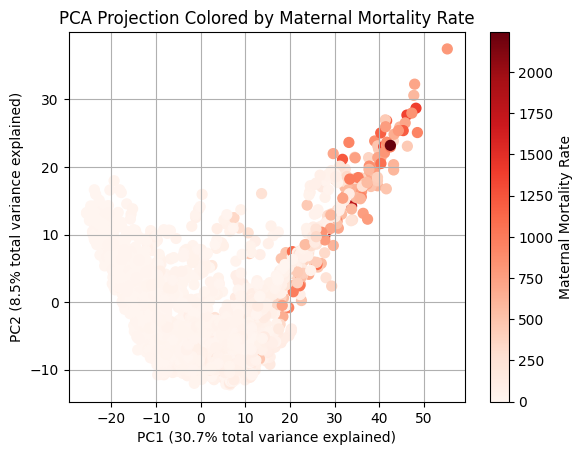

In [194]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=merged_relevant_dropped['Maternal mortality ratio (national estimate, per 100,000 live births)'], cmap='Reds', s=50)
plt.colorbar(label='Maternal Mortality Rate')
plt.title('PCA Projection Colored by Maternal Mortality Rate')
plt.xlabel('PC1 (30.7% total variance explained)')
plt.ylabel('PC2 (8.5% total variance explained)')
plt.grid(True)
plt.show()

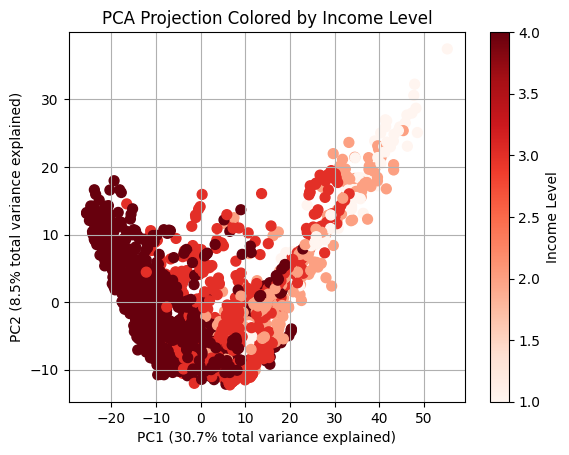

In [195]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=merged_relevant_dropped['income_num'], cmap='Reds', s=50)
plt.colorbar(label='Income Level')
plt.title('PCA Projection Colored by Income Level')
plt.xlabel('PC1 (30.7% total variance explained)')
plt.ylabel('PC2 (8.5% total variance explained)')
plt.grid(True)
plt.show()

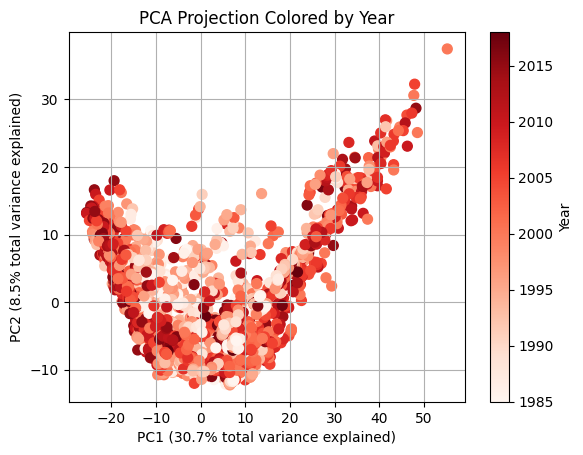

In [196]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=merged_relevant_dropped['date'], cmap='Reds', s=50)
plt.colorbar(label='Year')
plt.title('PCA Projection Colored by Year')
plt.xlabel('PC1 (30.7% total variance explained)')
plt.ylabel('PC2 (8.5% total variance explained)')
plt.grid(True)
plt.show()

### Key Statistics

In [ ]:
#mmr by income level 

In [135]:
merged_relevant_dropped[merged_relevant_dropped['income_num']==4]['Maternal mortality ratio (national estimate, per 100,000 live births)'].isnull().sum()

0

In [157]:
merged_relevant_dropped.groupby('income_num')["Cause of death, by non-communicable diseases, female (% of female population)"].apply(lambda x: x.isna().sum() / (x.shape[0]))

income_num
1.0    0.807692
2.0    0.890323
3.0    0.900602
4.0    0.906050
Name: Cause of death, by non-communicable diseases, female (% of female population), dtype: float64

In [136]:
mmr_median = pd.merge(merged_relevant_dropped.groupby('income_num')['Maternal mortality ratio (national estimate, per 100,000 live births)'].median(), 
merged_relevant_dropped.groupby('income_num')['Maternal mortality ratio (national estimate, per 100,000 live births)'].std(), on='income_num')
mmr_missing = merged_relevant_dropped.groupby('income_num')['Maternal mortality ratio (national estimate, per 100,000 live births)'].apply(lambda x: x.isna().sum() / (x.shape[0]))
mmr_median = pd.merge(mmr_median, mmr_missing, on='income_num')
mmr_median.columns = ['Maternal mortality ratio (national estimate, per 100,000 live births) Median', 'Std', 'Missing Data Proportion']
mmr_median

,"Maternal mortality ratio (national estimate, per 100,000 live births) Median",Std,Missing Data Proportion
income_num,,,
1.0,617.0,452.645833,0.0
2.0,55.5,259.860638,0.0
3.0,38.0,55.042100,0.0
4.0,8.0,20.852203,0.0


In [156]:
hiv_median = pd.merge(merged_relevant_dropped.groupby('income_num')['Women\'s share of population ages 15+ living with HIV (%)'].median(), 
merged_relevant_dropped.groupby('income_num')["Women's share of population ages 15+ living with HIV (%)"].std(), on='income_num')
hiv_missing = merged_relevant_dropped.groupby('income_num')["Women's share of population ages 15+ living with HIV (%)"].apply(lambda x: x.isna().sum() / (x.shape[0]))
hiv_median = pd.merge(hiv_median, hiv_missing, on='income_num')
hiv_median.columns = ["Women's share of population ages 15+ living with HIV (%) Median", 'Std', 'Missing Data Proportion']
hiv_median

,Women's share of population ages 15+ living with HIV (%) Median,Std,Missing Data Proportion
income_num,,,
1.0,58.9275,13.190321,0.000000
2.0,41.7850,16.370484,0.151613
3.0,31.0920,13.375277,0.183735
4.0,24.5475,10.383642,0.175801


In [ ]:
#income level 

In [137]:
pd.DataFrame(merged_relevant_dropped.groupby('income_num').size())

,0
income_num,
1.0,78
2.0,310
3.0,996
4.0,1405


In [138]:
'Women participating in own health care decisions (% of women age 15-49)'
health_decisions_median = pd.merge(merged_relevant_dropped.groupby('income_num')['Women participating in own health care decisions (% of women age 15-49)'].median(), 
merged_relevant_dropped.groupby('income_num')['Women participating in own health care decisions (% of women age 15-49)'].std(), on='income_num')
health_decisions_missing = merged_relevant_dropped.groupby('income_num')['Women participating in own health care decisions (% of women age 15-49)'].apply(lambda x: x.isna().sum() / (x.shape[0]))
health_decisions_median = pd.merge(health_decisions_median, health_decisions_missing, on='income_num')
health_decisions_median.columns = ['Women participating in own health care decisions (% of women age 15-49) Median', 'Std', 'Missing Data Proportion']
health_decisions_median

,Women participating in own health care decisions (% of women age 15-49) Median,Std,Missing Data Proportion
income_num,,,
1.0,59.5,21.958385,0.576923
2.0,66.7,22.470791,0.858065
3.0,84.1,8.740408,0.972892
4.0,91.0,NaN,0.999288


In [139]:
'Mortality rate, infant (per 1,000 live births)'
infant_mortality_median = pd.merge(merged_relevant_dropped.groupby('income_num')['Mortality rate, infant (per 1,000 live births)'].median(), 
merged_relevant_dropped.groupby('income_num')['Mortality rate, infant (per 1,000 live births)'].std(), on='income_num')
infant_mortality_missing = merged_relevant_dropped.groupby('income_num')['Mortality rate, infant (per 1,000 live births)'].apply(lambda x: x.isna().sum() / (x.shape[0]))
infant_mortality_median = pd.merge(infant_mortality_median, infant_mortality_missing, on='income_num')
infant_mortality_median.columns = ['Mortality rate, infant (per 1,000 live births) Median', 'Std', 'Missing Data Proportion']
infant_mortality_median

,"Mortality rate, infant (per 1,000 live births) Median",Std,Missing Data Proportion
income_num,,,
1.0,64.80,29.358087,0.000000
2.0,39.25,23.205178,0.000000
3.0,19.40,15.094476,0.000000
4.0,6.90,6.755616,0.022776


In [140]:
'Pregnant women receiving prenatal care (%)'
prenatal_care_median = pd.merge(merged_relevant_dropped.groupby('income_num')['Pregnant women receiving prenatal care (%)'].median(), 
merged_relevant_dropped.groupby('income_num')['Pregnant women receiving prenatal care (%)'].std(), on='income_num')
prenatal_care_missing = merged_relevant_dropped.groupby('income_num')['Pregnant women receiving prenatal care (%)'].apply(lambda x: x.isna().sum() / (x.shape[0]))
prenatal_care_median = pd.merge(prenatal_care_median, prenatal_care_missing, on='income_num')
prenatal_care_median.columns = ['Pregnant women receiving prenatal care (%) Median', 'Std', 'Missing Data Proportion']
prenatal_care_median

,Pregnant women receiving prenatal care (%) Median,Std,Missing Data Proportion
income_num,,,
1.0,84.50,23.358046,0.282051
2.0,85.90,18.138300,0.648387
3.0,95.80,9.702199,0.780120
4.0,96.55,8.425194,0.948754


In [141]:
"Stillbirth rate (per 1,000 total births)"
stillbirth_rate_median = pd.merge(merged_relevant_dropped.groupby('income_num')["Stillbirth rate (per 1,000 total births)"].median(), 
merged_relevant_dropped.groupby('income_num')["Stillbirth rate (per 1,000 total births)"].std(), on='income_num')
stillbirth_rate_missing = merged_relevant_dropped.groupby('income_num')["Stillbirth rate (per 1,000 total births)"].apply(lambda x: x.isna().sum() / (x.shape[0]))
stillbirth_rate_median = pd.merge(stillbirth_rate_median, stillbirth_rate_missing, on='income_num')
stillbirth_rate_median.columns = ['Stillbirth rate (per 1,000 total births) Median', 'Std', 'Missing Data Proportion']
stillbirth_rate_median

,"Stillbirth rate (per 1,000 total births) Median",Std,Missing Data Proportion
income_num,,,
1.0,22.9,6.477547,0.153846
2.0,13.3,6.419003,0.312903
3.0,9.6,4.181028,0.384538
4.0,3.3,2.609547,0.440569


In [142]:
"1.0.0 Communicable, maternal, neonatal, and nutritional diseases prevalence (age standardized) (per 100 000 population) female"
disease_prevalence_median = pd.merge(merged_relevant_dropped.groupby('income_num')["1.0.0 Communicable, maternal, neonatal, and nutritional diseases prevalence (age standardized) (per 100 000 population) female"].median(), 
merged_relevant_dropped.groupby('income_num')["1.0.0 Communicable, maternal, neonatal, and nutritional diseases prevalence (age standardized) (per 100 000 population) female"].std(), on='income_num')
disease_prevalence_missing = merged_relevant_dropped.groupby('income_num')["1.0.0 Communicable, maternal, neonatal, and nutritional diseases prevalence (age standardized) (per 100 000 population) female"].apply(lambda x: x.isna().sum() / (x.shape[0]))
disease_prevalence_median = pd.merge(disease_prevalence_median, disease_prevalence_missing, on='income_num')
disease_prevalence_median.columns = ["1.0.0 Communicable, maternal, neonatal, and nutritional diseases prevalence (age standardized) (per 100 000 population) female Median", 'Std', 'Missing Data Proportion']
disease_prevalence_median

,"1.0.0 Communicable, maternal, neonatal, and nutritional diseases prevalence (age standardized) (per 100 000 population) female Median",Std,Missing Data Proportion
income_num,,,
1.0,84660.949219,14140.550603,0.769231
2.0,73278.921875,9389.262776,0.841935
3.0,63091.880859,10657.589286,0.863454
4.0,36806.753906,11821.396330,0.874021


In [149]:
"Survival to age 65, female (% of cohort)"
fem_survival_median = pd.merge(merged_relevant_dropped.groupby('income_num')["Survival to age 65, female (% of cohort)"].median(), 
merged_relevant_dropped.groupby('income_num')["Survival to age 65, female (% of cohort)"].std(), on='income_num')
fem_survival_missing = merged_relevant_dropped.groupby('income_num')['Survival to age 65, female (% of cohort)'].apply(lambda x: x.isna().sum() / (x.shape[0]))
fem_survival_median = pd.merge(fem_survival_median, fem_survival_missing, on='income_num')
fem_survival_median.columns = ['Survival to age 65, female (% of cohort) Median', 'Std', 'Missing Data Proportion']
fem_survival_median

,"Survival to age 65, female (% of cohort) Median",Std,Missing Data Proportion
income_num,,,
1.0,57.5480,13.356000,0.0
2.0,73.0700,12.235471,0.0
3.0,80.0065,7.879657,0.0
4.0,88.3050,5.164306,0.0


In [144]:
"Births attended by skilled health staff (% of total)"
birth_skilled_median = pd.merge(merged_relevant_dropped.groupby('income_num')["Births attended by skilled health staff (% of total)"].median(), 
merged_relevant_dropped.groupby('income_num')["Births attended by skilled health staff (% of total)"].std(), on='income_num')
birth_skilled_missing = merged_relevant_dropped.groupby('income_num')["Births attended by skilled health staff (% of total)"].apply(lambda x: x.isna().sum() / (x.shape[0]))
birth_skilled_median = pd.merge(birth_skilled_median, birth_skilled_missing, on='income_num')
birth_skilled_median.columns = ['Births attended by skilled health staff (% of total) Median', 'Std', 'Missing Data Proportion']
birth_skilled_median

,Births attended by skilled health staff (% of total) Median,Std,Missing Data Proportion
income_num,,,
1.0,45.0,23.483336,0.269231
2.0,75.1,24.820573,0.422581
3.0,98.6,9.105211,0.331325
4.0,99.6,1.791267,0.385053


In [145]:
'Unmet need for contraception (% of married women ages 15-49)'
contra_need_median = pd.merge(merged_relevant_dropped.groupby('income_num')['Unmet need for contraception (% of married women ages 15-49)'].median(), 
merged_relevant_dropped.groupby('income_num')['Unmet need for contraception (% of married women ages 15-49)'].std(), on='income_num')
contra_need_missing = merged_relevant_dropped.groupby('income_num')['Unmet need for contraception (% of married women ages 15-49)'].apply(lambda x: x.isna().sum() / (x.shape[0]))
contra_need_median = pd.merge(contra_need_median, contra_need_missing, on='income_num')
contra_need_median.columns = ['Unmet need for contraception (% of married women ages 15-49) Median', 'Std', 'Missing Data Proportion']
contra_need_median

,Unmet need for contraception (% of married women ages 15-49) Median,Std,Missing Data Proportion
income_num,,,
1.0,27.5500,6.564645,0.333333
2.0,22.8895,7.550450,0.722581
3.0,12.1160,6.362408,0.875502
4.0,10.0490,10.070294,0.970107
